# Ordinal Regression

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from tqdm import tqdm

plt.ion()

## Data Preperation

In [2]:
import sys
sys.path.append('../../data/weebit')
from weebit_loader import X_train, y_train, y_train_onehot, X_test, y_test, y_test_onehot

Using TensorFlow backend.


## Classical ML

In [3]:
from mord import LogisticAT, LogisticIT, LAD, OrdinalRidge 
from sklearn.model_selection import GridSearchCV


def train_ordinal_regression_model(model_class, X_train, y_train, model_params={}, hyperparameters_grid={}):
    
    name = model_class.__name__

    try:
        model = model_class(random_state=42, **model_params)
    except TypeError:
        model = model_class(**model_params)

    if hyperparameters_grid:
        model = GridSearchCV(model, hyperparameters_grid)
        # name += ' GridCV'
    
    model.fit(X_train, y_train)
    
    return name, model


ALPHAs = 10.**np.arange(-4, 5)
Cs = 10.**np.arange(-4, 5)

models = dict([train_ordinal_regression_model(model_class, X_train, y_train, model_params, hyperparameters_grid)
          for model_class, model_params, hyperparameters_grid in
                                     tqdm([
                                         (LogisticAT, {},  {'alpha': ALPHAs}),
                                         (LogisticIT, {},  {'alpha': ALPHAs}),
                                         (LAD, {}, {'C': Cs}),
                                         (OrdinalRidge, {}, {'alpha': ALPHAs}),
                                     ])])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:40<00:00, 10.06s/it]


## MLP - TODO?

http://ttic.uchicago.edu/~nati/Publications/RennieSrebroIJCAI05.pdf

## Evaluation

In [4]:
import itertools
import functools
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score,\
                            classification_report, accuracy_score, confusion_matrix, f1_score


def threshold_socre(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

   
def calc_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test).flatten()
    
    y_pred_classes = np.clip(y_pred.round().astype(int), 0, 4)

    metrics = {}

    metrics.update({metrics.__name__: metrics(y_test, y_pred) for metrics in [mean_absolute_error,
                                                                      mean_squared_error,
                                                                      explained_variance_score,                                                                      explained_variance_score,
                                                                      r2_score
    ]})
    
    metrics.update({metrics.__name__: metrics(y_test, y_pred_classes) for metrics in [accuracy_score,
                                                              classification_report,
                                                              confusion_matrix,
                                                              f1_score_micro,
                                                              threshold_socre,
    ]})

    return metrics

evaluation_df = pd.DataFrame({name: calc_metrics(model, X_test, y_test) for name, model in models.items()}).transpose()
evaluation_df = evaluation_df.sort_values('threshold_socre', ascending=False)

In [5]:
summary_evaluation_df = (evaluation_df[['accuracy_score', 'f1_score_micro', 'threshold_socre', 'mean_absolute_error']]
     .astype(float).round(4))

summary_evaluation_df

,accuracy_score,f1_score_micro,threshold_socre,mean_absolute_error
LAD,0.4808,0.4808,0.9121,0.6140
LogisticAT,0.4615,0.4615,0.9121,0.6305
OrdinalRidge,0.4560,0.4560,0.9121,0.6360
LogisticIT,0.4945,0.4945,0.8915,0.6277


In [6]:
summary_evaluation_df.to_excel('ordinal_regression_evaluation.xlsx')

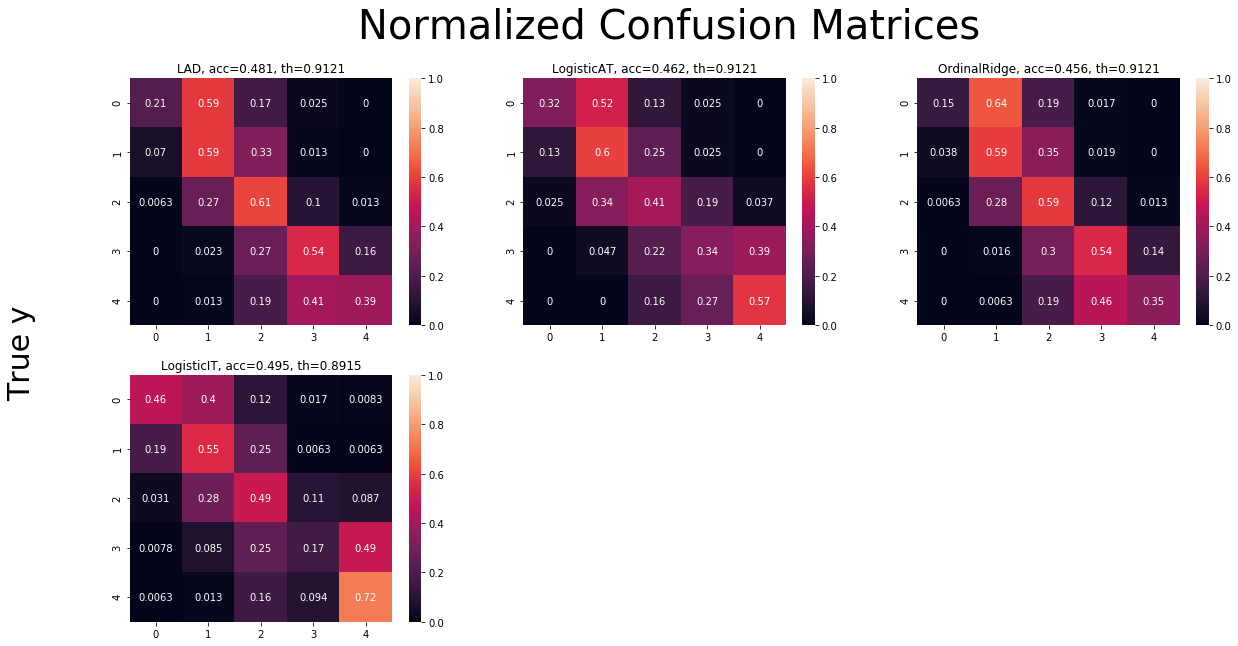

In [7]:
f, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = itertools.chain(*axes)
for (name, r), ax in zip(evaluation_df.iterrows(), axes):
    cm = r['confusion_matrix']
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmin=0, vmax=1, annot=True,
                ax=ax)
    ax.set_title(name + ', acc={:0.3f}, th={:0.4f}'.format(r['accuracy_score'], r['threshold_socre']))

for ax in axes:
    ax.set_visible(False)

f.text(0.04, 0.5, 'True y', va='center', rotation='vertical', fontsize=30)
f.suptitle('Normalized Confusion Matrices', fontsize=40);

### Probs Analysis

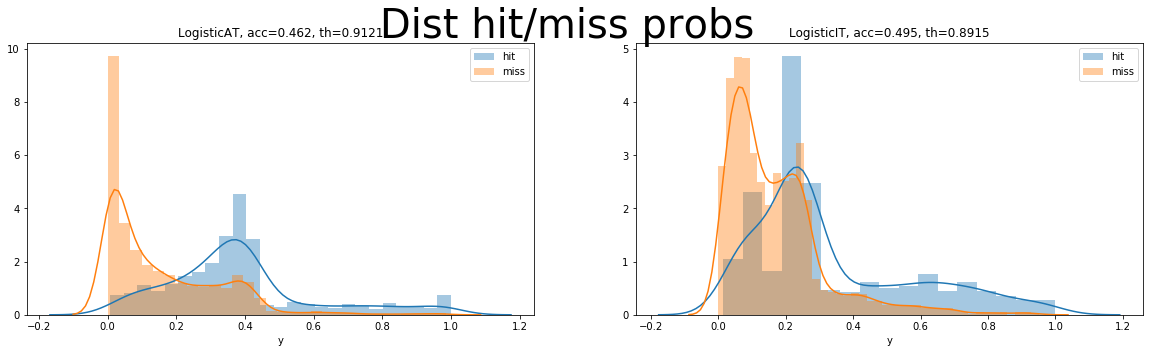

In [8]:
f, axes = plt.subplots(1, 2, figsize=(20, 5))
#axes = itertools.chain(*axes)
for (name, r), ax in zip(evaluation_df[evaluation_df.index.isin(['LogisticAT', 'LogisticIT'])].iterrows(), axes):

    model = models[name]
    try:
        y_pred_probs = model.predict_proba(X_test)
    except AttributeError:
        continue
    
    assert np.allclose(y_pred_probs.sum(axis=1), 1)
    
    sns.distplot(np.choose(y_test, y_pred_probs.T), label='hit', ax=ax)


    sns.distplot(np.array([[prob for index, prob in enumerate(probs) 
                      if cls != index ]
                 for probs, cls in  zip(y_pred_probs, y_test)]).flatten(),
             label='miss', ax=ax)

    ax.set_title(name + ', acc={:0.3f}, th={:0.4f}'.format(r['accuracy_score'], r['threshold_socre']))
    ax.legend()


f.suptitle('Dist hit/miss probs', fontsize=40);

### Average y as Regression

In [9]:
import itertools
import functools
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score,\
                            classification_report, accuracy_score, confusion_matrix, f1_score


def threshold_socre(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

   
def calc_metrics(model, X_test, y_test):

    y_pred_probs = model.predict_proba(X_test)
    y_pred_avg = (y_pred_probs * np.arange(5)).sum(axis=1)
    y_pred_avg_classes = y_pred_avg.round().clip(0, 4).astype(int)

    metrics = {}

    metrics.update({metrics.__name__: metrics(y_test, y_pred_avg) for metrics in [mean_absolute_error,
                                                                      mean_squared_error,
                                                                      explained_variance_score,                                                                      explained_variance_score,
                                                                      r2_score
                                                                      
    ]})
    
    metrics.update({metrics.__name__: metrics(y_test, y_pred_avg_classes) for metrics in [accuracy_score,
                                                              classification_report,
                                                              confusion_matrix,
                                                              f1_score_micro,
                                                              threshold_socre,
    ]})

    return metrics

evaluation_df = pd.DataFrame({name: calc_metrics(model, X_test, y_test) for name, model in models.items()
                             if name in ['LogisticAT', 'LogisticIT']}).transpose()
evaluation_df = evaluation_df.sort_values('threshold_socre', ascending=False)

In [10]:
summary_evaluation_df = (evaluation_df[['accuracy_score', 'f1_score_micro', 'threshold_socre', 'mean_squared_error', 'mean_absolute_error', 'explained_variance_score', 'r2_score']]
     .astype(float).round(4))
summary_evaluation_df

,accuracy_score,f1_score_micro,threshold_socre,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
LogisticIT,0.4409,0.4409,0.9217,0.7554,0.6881,0.6095,0.6094
LogisticAT,0.4533,0.4533,0.9162,0.7155,0.6629,0.6303,0.6300


In [11]:
summary_evaluation_df.to_excel('probs_avg_ordinal_regression_evaluation.xlsx')